# Preprocessing Time Analysis for Different File Formats

Introduction:

ICESat-2's rich hierarchical photon data, primarily stored in HDF5 formats, presents both advantages and challenges. While HDF5 files excel in supporting diverse scientific workflows due to their self-describing nature and ability to house heterogeneous data, their serialization structure requires users to load an entire ATL03 HDF5 file even when only a subset is desired. This contrasts with raster data formats like cloud-optimized GeoTIFFs, which allow efficient partial data access.

In our quest to optimize data access, we explore various file formats and preprocessing techniques. This includes traditional methods and cutting-edge approaches such as using kerchunk, a library designed to enhance chunked data access in cloud environments.

Objective:

In this section, we will analyze the preprocessing time taken for different file formats, including 'kerchunked', 'original h5', 'repacked', 'kerchunked of repacked', and 'geoparquet'. By benchmarking these times, we aim to identify the most efficient file structure for ICESat-2 data retrieval, both in terms of speed and computational resources.



## Generating Kerchunk sidecar for ATL03 files
You're creating an accompanying metadata file (much like sidecar in motorbike which ride along with the primary file) using the Kerchunk library for the ATL03 data files. In the context of Kerchunk, the sidecar would contain metadata, byte range locations, compression information, and other essential details that allow for efficient, chunked access to the main data file without needing to read the whole file.

Setting Up the Environment for Kerchunk Processing with ATL03 Files

In [ ]:
%%capture
%pip install git+https://github.com/fsspec/kerchunk

# restart the kernel after this

In [ ]:
from kerchunk.hdf import SingleHdf5ToZarr
import fsspec
from pathlib import Path

import os
import ujson
import dask

In [ ]:
# Initialize connection to the AWS S3 filesystem for reading files.
fs_read_files = fsspec.filesystem('s3')

# Create a list of all files present in the specified S3 directory. Here I am using one of the files.
flist = fs_read_files.glob('s3://nasa-cryo-scratch/h5cloud/original/ATL03_20200217204710_08110612_006_01.h5')

def gen_json(file_url):
    """
    Generate a JSON representation of the chunked structure of an HDF5 file.

    Args:
    - file_url (str): URL to the HDF5 file hosted on S3 bucket.
    """
    
    # Configuration for opening the file: Avoid caching to reduce memory usage.
    so = dict(mode='rb', default_fill_cache=False, default_cache_type='first')
    
    # Initialize connection to the S3 filesystem.
    fs = fsspec.filesystem('s3')
    
    # Initialize connection to the local filesystem for saving JSON outputs.
    fs_local = fsspec.filesystem('')  
    
    # Open and process the HDF5 file from S3.
    with fs.open(file_url, **so) as infile:
        print(f"Processing: {file_url}")
        
        # Convert the HDF5 data structure for optimized cloud access.
        h5chunks = SingleHdf5ToZarr(infile, file_url, inline_threshold=300)
        
        # Determine the name of the output JSON file based on the input file's name and directory.
        variable = file_url.split('/')[-1].split('.')[0]
        month = file_url.split('/')[2]
        outf = f'{month}_{variable}.json'
        
        # Save the processed data as a JSON file locally.
        with fs_local.open(f"./{outf}", 'wb') as f:
            f.write(ujson.dumps(h5chunks.translate()).encode())

# Display the list of files to be processed.
flist


### Function Internals:

- The function sets up the S3 filesystem and a local filesystem.
- It opens the provided HDF5 file from S3 and processes it with `SingleHdf5ToZarr`, which is designed to create an indexed file optimized for cloud access (Zarr).
- The resulting representation is then saved as a JSON file locally in the `./kerchunked/` directory.


### Preprocessing Time calculation

In [ ]:
import time

original_data = 's3://nasa-cryo-scratch/h5cloud/original/ATL03_20200217204710_08110612_006_01.h5'

# file formats or files to process
file_url = original_data


# Start the timer
start_time = time.time()

# Call the preprocessing function
kerchunked_json = gen_json(file_url)

# End the timer and store the result
end_time = time.time()
preprocess_time_kerchunk = end_time - start_time

print(f"Time taken for preprocessing using Kerchunk: {preprocess_time_kerchunk:.2f} seconds")




## Generating Geoparquet Data Samples from ATL03 Samples

This process focuses on converting ICESat-2's ATL03 data samples, into the geoparquet format. Geoparquet is a columnar storage file format optimized for big data processing. By converting ATL03 samples to geoparquet, we can achieve more efficient data access and processing, especially in cloud-based environments.

Detailed Steps:
1. Convert ATL03 Samples to Geoparquet:

Begin by taking the ATL03 data samples, which represent whole granules, and initiate the process to convert them into the geoparquet format. This step ensures that our data is in a format suitable for fast querying and analysis.
 
2. Use SlideRule with Geoparquet Export Option:

SlideRule is a processing engine designed to work with ICESat-2 data. In this step, utilize SlideRule's capability to handle geoparquet by choosing the geoparquet export option. This will allow you to download the desired ATL03 data granules by specifying their IDs.

3. Save Data to a Common Bucket:

After downloading the converted data granules, save them to a common data bucket. This central storage ensures easy accessibility for further analysis and sharing.
Reference Guide:

For a detailed walkthrough of the process, especially the steps involving SlideRule, refer to the tutorial available at ICESat-2 Hackweek SlideRule Tutorial. This guide provides comprehensive instructions, tips, and best practices for working with ICESat-2 data and the geoparquet format.

In [ ]:

os.environ['USE_PYGEOS'] = '0'
from sliderule import icesat2, earthdata, io
import boto3

In [ ]:
# Initialize the connection to SlideRule service
icesat2.init("slideruleearth.io")

In [ ]:
# List of granules to process, we are using one granule to test but it can be more
granule = 'ATL03_20200217204710_08110612_006_01.h5'

In [ ]:
# Fetch AWS credentials for accessing S3 resources and these credentials are needed for sliderule
client = boto3.client('sts')
with open(os.environ['AWS_WEB_IDENTITY_TOKEN_FILE']) as f:
    TOKEN = f.read()

response = client.assume_role_with_web_identity(
    RoleArn=os.environ['AWS_ROLE_ARN'],
    RoleSessionName=os.environ['JUPYTERHUB_CLIENT_ID'],
    WebIdentityToken=TOKEN,
    DurationSeconds=3600
)

ACCESS_KEY_ID = response['Credentials']['AccessKeyId']
SECRET_ACCESS_KEY_ID = response['Credentials']['SecretAccessKey']
SESSION_TOKEN = response['Credentials']['SessionToken']


In [ ]:
# Function to convert a given ATL03 granule to geoparquet format and save to S3
def get_gpq(granule):
    asset = "icesat2"
    # Define the S3 path for the output geoparquet file
    output = f"s3://nasa-cryo-scratch/h5cloud/geoparquet/{granule}.gpq"
    
    # Configuration parameters for the conversion process
    params = {
        "output": {
            "path": output,
            "format": "parquet",
            "open_on_complete": False,
            "region": "us-west-2",
            "credentials": {
                 "aws_access_key_id": ACCESS_KEY_ID,
                 "aws_secret_access_key": SECRET_ACCESS_KEY_ID,
                 "aws_session_token": SESSION_TOKEN
             }
        }
    }
    
    # Convert ATL03 granule to geoparquet using the SlideRule service
    status = icesat2.atl03s(parm=params, resource=granule, asset=asset)
    
    return status

In [ ]:

%%time
# Convert all granules in the list to geoparquet format
result = get_gpq(granule)
print(result)

## Repacking h5 dataset

In [ ]:
import subprocess

def repack_hdf5(input_file, options=[]):
    cmd = ["h5repack"] + options + [input_file, output_file]
    subprocess.run(cmd)
    
# Start the timer
start_time = time.time()

# Usage
input_file = "s3://nasa-cryo-scratch/h5cloud/original/ATL03_20200217204710_08110612_006_01.h5"
output_file = "h5repacked.h5"
repack_hdf5(input_file, options=["-S", "PAGE", "-G", "8000000"])

# End the timer and store the result
end_time = time.time()
preprocess_time = end_time - start_time



## Generating Kerchunk sidecar h5repacked data

When we talk about "Generating Kerchunk sidecar for h5repacked data," we are referring to the process of creating a Kerchunk sidecar metadata file specifically for an HDF5 file that has undergone the repacking process. This combination allows for the benefits of both techniques:

Efficient Data Structure: Thanks to h5repacking, the HDF5 file itself is optimized for faster read operations.
Optimized Access: The Kerchunk sidecar allows for chunked, efficient access, especially beneficial in cloud-based workflows. It means applications can pull specific chunks of data without downloading or reading the entire file.

In [ ]:
# Initialize connection to the AWS S3 filesystem for reading files.
fs_read_files = fsspec.filesystem('s3')

In [ ]:


h5repack_data = 's3://nasa-cryo-scratch/h5cloud/h5repack/ATL03_20200217204710_08110612_006_01_repacked.h5'

# file formats or files to process
file_url = h5repack_data


# Start the timer
start_time = time.time()

# Call the preprocessing function
kerchunked_json = gen_json(file_url)

# End the timer and store the result
end_time = time.time()
preprocess_time = end_time - start_time

print(f"Time taken for preprocessing using Kerchunk: {preprocess_time:.2f} seconds")


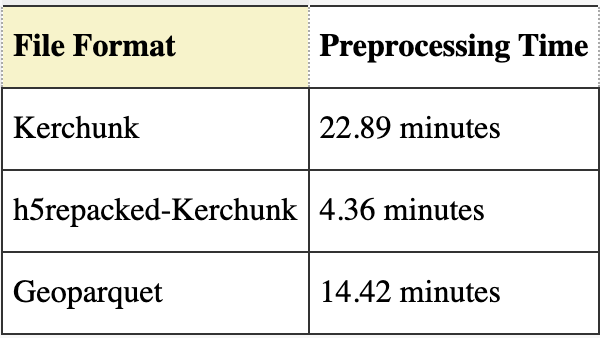